<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Lung_Disease_%7C_TensorCTScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
fatemehmehrparvar_lung_disease_path = kagglehub.dataset_download('fatemehmehrparvar/lung-disease')

print('Data source import complete.')


Using Colab cache for faster access to the 'lung-disease' dataset.
Data source import complete.


![f341cc-20230919-a-doctor-uses-ai-medicine-2000.jpg](attachment:3fdf4aad-a8d2-4141-8aa8-a4495acdbd0d.jpg)

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Import Libraries </h3>
    
</div>


In [2]:
pip install pydicom kornia opencv-python scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 115.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt

from pathlib import Path
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import accuracy, F1Score
from fastai.medical.imaging import get_dicom_files
from fastai.medical.imaging import TensorCTScan
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Load Data </h3>
    
</div>


In [4]:
path = Path("/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image")

In [5]:
lung_source = untar_data(URLs.SIIM_SMALL)
lung_source

<div><progress max="33276453" value="33284096"></progress> 100.02% [33284096/33276453 00:01&lt;00:00]</div>

Path('/root/.fastai/data/siim_small')

In [6]:
items = get_dicom_files(lung_source/"train/")

In [7]:
trn,val = RandomSplitter()(items)

In [8]:
patient = 7
xray_sample = items[patient].dcmread()
xray_sample

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.12979.1517875242.846655
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12979.1517875242.846655
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                  

In [9]:
xray_sample.PixelData[:250]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\x00\x0c\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x06\x00\x07\x08\t\xff\xc4\x00Z\x10\x00\x02\x01\x03\x03\x03\x03\x01\x05\x07\x00\x06\x07\x03\x00\x1b\x01\x02\x11\x00\x03!\x04\x121\x05AQ\x13"aq\x062\x81\x91\xa1\x07\x14#B\xb1\xc1\xd1\x08\x15$R\xe1\xf0\x16\x17%3br\xf14CDT\x18&5tu\x826EUde\x92\xb2\t7Gs\x83\xa2\'Fc\x85\x93\xa3\xc2\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xfc;\xf6<\x1f\xfa=\xd3\x08$\x95\xd2#\x1c\xe0\x08\xe2'

In [10]:
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[  0,  39,  55, ...,   5,   5,   5],
        [  0,  35,  49, ...,   5,   5,   5],
        [  2,  33,  48, ...,   5,   5,   5],
        ...,
        [  0,  76, 122, ...,  12,  12,  11],
        [  7,  61,  93, ...,   8,   8,   7],
        [  0,   1,   0, ...,   0,   0,   0]], dtype=uint8),
 (1024, 1024))

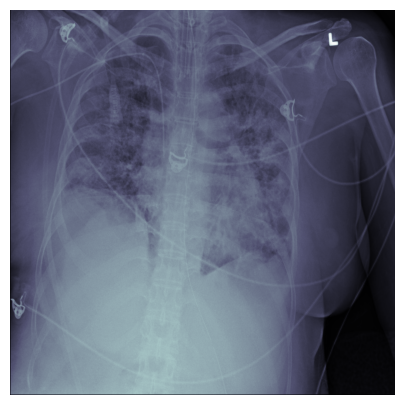

In [11]:
tensor_ct = TensorCTScan(xray_sample.pixel_array)
tensor_ct.show();

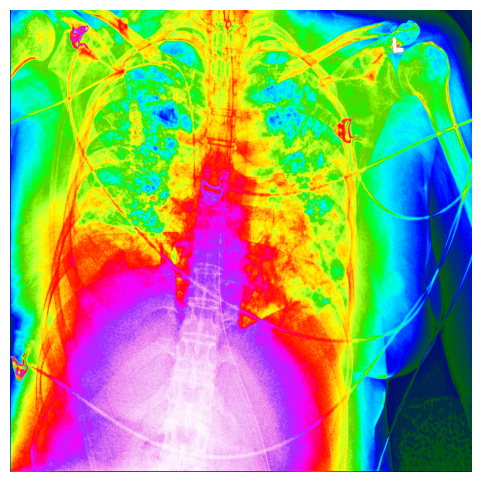

In [12]:
xray_sample.show(cmap=plt.cm.gist_ncar, figsize=(6,6))

In [13]:
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:5]

SpecificCharacterSet                SOPClassUID  \
0           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
1           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
2           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
3           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
4           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   

                                            SOPInstanceUID StudyDate  \
0   1.2.276.0.7230010.3.1.4.8323329.2013.1517875170.692242  19010101   
1  1.2.276.0.7230010.3.1.4.8323329.12954.1517875242.700587  19010101   
2   1.2.276.0.7230010.3.1.4.8323329.3288.1517875177.106544  19010101   
3  1.2.276.0.7230010.3.1.4.8323329.10888.1517875226.128268  19010101   
4  1.2.276.0.7230010.3.1.4.8323329.11691.1517875234.327235  19010101   

   StudyTime AccessionNumber Modality ConversionType ReferringPhysicianName  \
0  000000.00                       CR            WSD                     ()   
1  000000.00                       CR            WSD                     ()   
2  000000.00                       CR            WSD                     ()   
3  000000.00                       CR            WSD                     ()   
4  000000.00                       CR            WSD                     ()   

  SeriesDescription  ... HighBit PixelRepresentation LossyImageCompression  \
0          view: AP  ...       7                   0                    01   
1          view: AP  ...       7                   0                    01   
2          view: PA  ...       7                   0                    01   
3          view: AP  ...       7                   0                    01   
4          view: PA  ...       7                   0                    01   

  LossyImageCompressionMethod  \
0                 ISO_10918_1   
1                 ISO_10918_1   
2                 ISO_10918_1   
3                 ISO_10918_1   
4                 ISO_10918_1   

                                                            fname img_min  \
0  /root/.fastai/data/siim_small/train/No Pneumothorax/000147.dcm       0   
1  /root/.fastai/data/siim_small/train/No Pneumothorax/000244.dcm       0   
2  /root/.fastai/data/siim_small/train/No Pneumothorax/000167.dcm       0   
3  /root/.fastai/data/siim_small/train/No Pneumothorax/000069.dcm       0   
4  /root/.fastai/data/siim_small/train/No Pneumothorax/000249.dcm       0   

  img_max    img_mean    img_std img_pct_window  
0     255  107.269248  52.738122       0.300745  
1     255  124.715261  51.732013       0.145900  
2     244  119.318038  76.554403       0.349136  
3     255  118.851926  47.788729       0.209922  
4     245  137.302234  72.359089       0.238268  

[5 rows x 42 columns]

In [14]:
df = pd.read_csv(lung_source/f"labels.csv")
df.head()

file            label
0  train/No Pneumothorax/000000.dcm  No Pneumothorax
1     train/Pneumothorax/000001.dcm     Pneumothorax
2  train/No Pneumothorax/000002.dcm  No Pneumothorax
3     train/Pneumothorax/000003.dcm     Pneumothorax
4     train/Pneumothorax/000004.dcm     Pneumothorax

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Data Splitting: </h3>
    
</div>


In [15]:
lung_disease = DataBlock(blocks=(ImageBlock, CategoryBlock),
                                get_items=get_image_files,
                                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                                get_y=parent_label,
                                item_tfms=Resize(224))

dls = lung_disease.dataloaders(path)

In [16]:
len(dls.train_ds)

2780

In [17]:
len(dls.valid_ds)

695

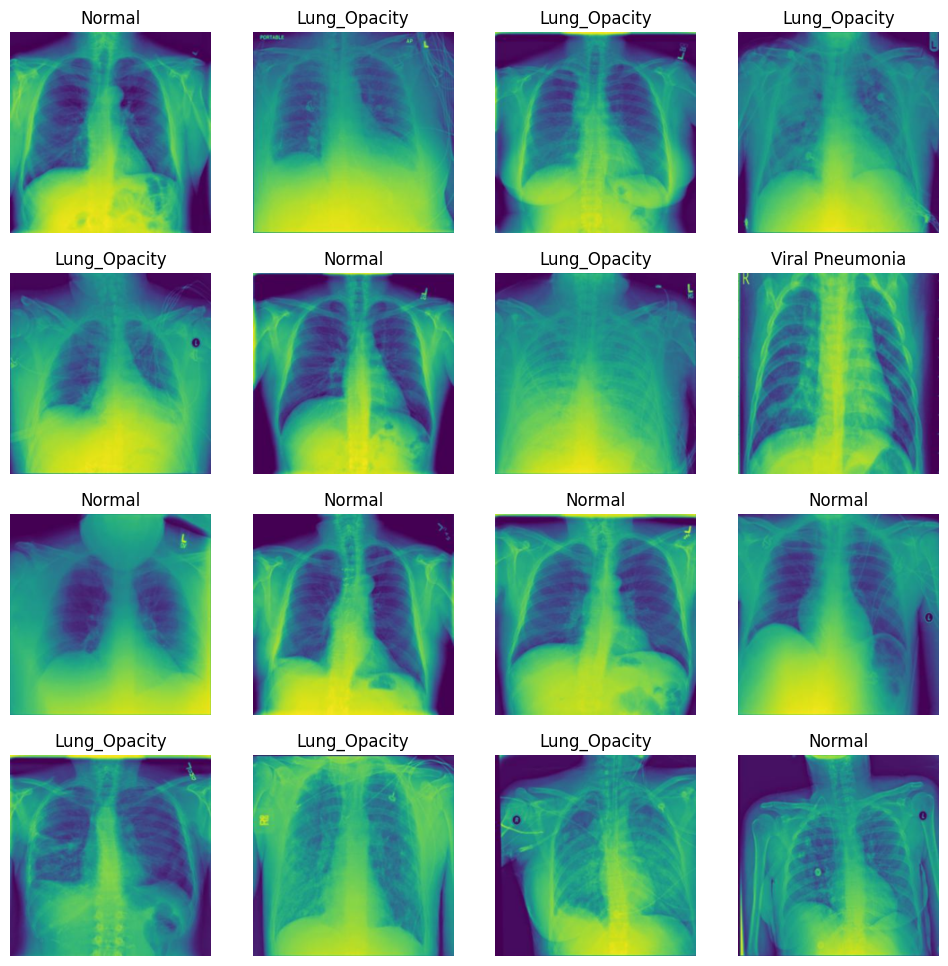

In [18]:
dls.show_batch(max_n=16)

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Data Training </h3>
    
</div>


In [19]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


In [20]:
learn.model_dir = "/kaggle/working/"

In [21]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [22]:
learn.summary()

<div></div>

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [23]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

<div></div>

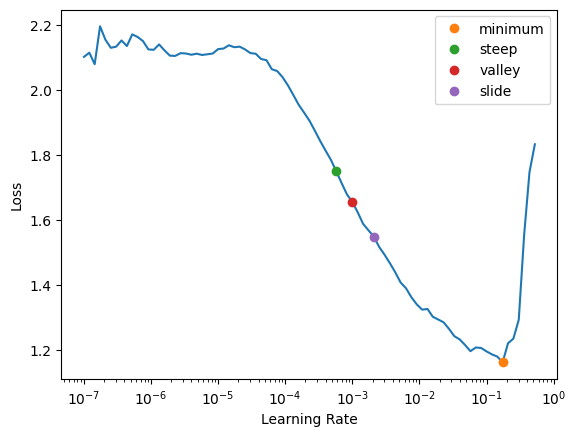

In [24]:
suggest_funcs = (minimum, steep, valley, slide)

lrs = learn.lr_find(suggest_funcs=suggest_funcs)

<div><table class="fastprogress"><thead><tr><th>epoch</th><th>train_loss</th><th>valid_loss</th><th>accuracy</th><th>time</th></tr></thead><tbody><tr><td>0</td><td>0.801960</td><td>0.409304</td><td>0.871942</td><td>00:15</td></tr><tr><td>1</td><td>0.494677</td><td>0.329524</td><td>0.887770</td><td>00:13</td></tr><tr><td>2</td><td>0.297965</td><td>0.329561</td><td>0.887770</td><td>00:13</td></tr><tr><td>3</td><td>0.187544</td><td>0.328406</td><td>0.884892</td><td>00:13</td></tr><tr><td>4</td><td>0.125540</td><td>0.332666</td><td>0.886331</td><td>00:13</td></tr></tbody></table></div>

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

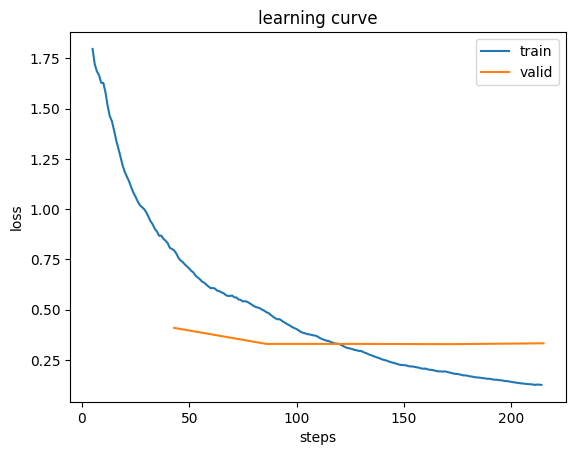

In [25]:
learn.fit_one_cycle(5, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

In [26]:
tta = learn.tta(use_max=True)

<div><div><progress max="5" value="0"></progress> 0.00% [0/5 00:00&lt;?]</div><div><table class="fastprogress"><thead><tr><th>epoch</th><th>train_loss</th><th>valid_loss</th><th>accuracy</th><th>time</th></tr></thead><tbody></tbody></table></div></div>

<div></div>

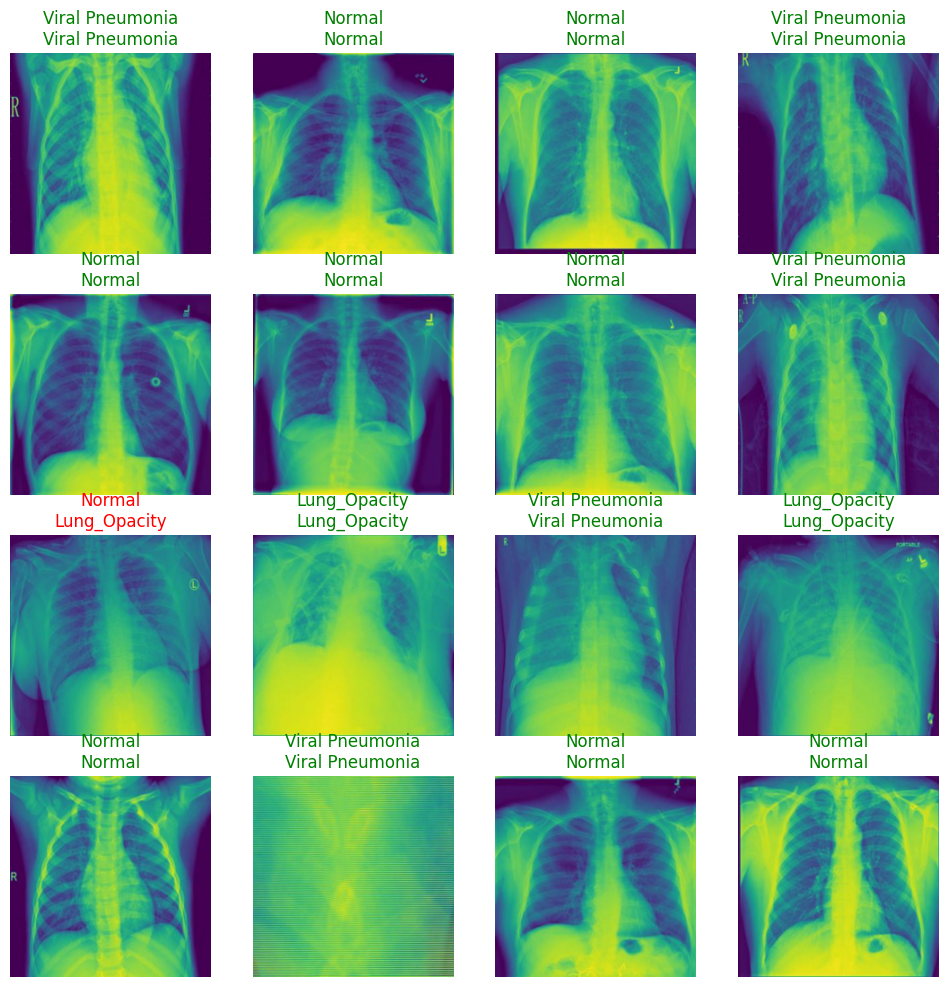

In [27]:
learn.show_results(max_n=16)

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Optimization and Fine-tuning </h3>
    
</div>


<div></div>

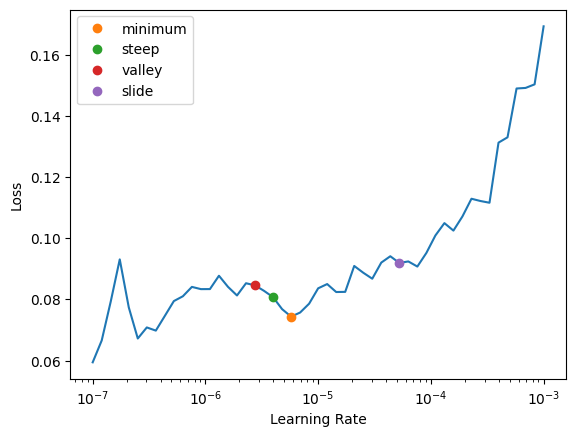

In [28]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

<div><table class="fastprogress"><thead><tr><th>epoch</th><th>train_loss</th><th>valid_loss</th><th>accuracy</th><th>time</th></tr></thead><tbody><tr><td>0</td><td>0.077186</td><td>0.331044</td><td>0.890647</td><td>00:17</td></tr><tr><td>1</td><td>0.061250</td><td>0.322166</td><td>0.896403</td><td>00:17</td></tr><tr><td>2</td><td>0.048395</td><td>0.345671</td><td>0.897842</td><td>00:18</td></tr><tr><td>3</td><td>0.043731</td><td>0.322398</td><td>0.893525</td><td>00:18</td></tr><tr><td>4</td><td>0.029782</td><td>0.341048</td><td>0.902158</td><td>00:17</td></tr><tr><td>5</td><td>0.022242</td><td>0.342888</td><td>0.894964</td><td>00:18</td></tr><tr><td>6</td><td>0.017323</td><td>0.351130</td><td>0.899281</td><td>00:17</td></tr><tr><td>7</td><td>0.013332</td><td>0.349541</td><td>0.894964</td><td>00:17</td></tr><tr><td>8</td><td>0.011282</td><td>0.347648</td><td>0.899281</td><td>00:18</td></tr><tr><td>9</td><td>0.010353</td><td>0.348648</td><td>0.897842</td><td>00:17</td></tr></tbody></table></div>

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

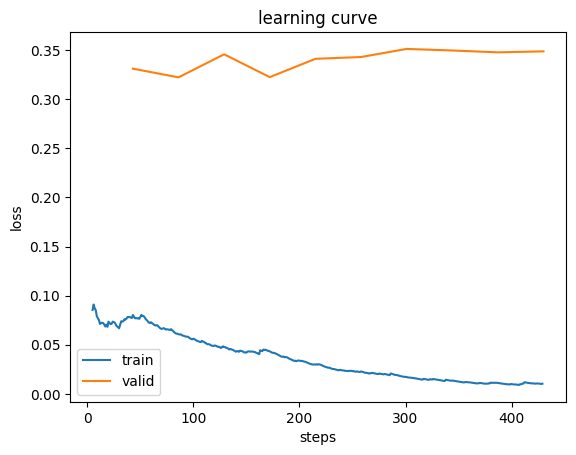

In [29]:
learn.fit_one_cycle(10, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

In [30]:
tta = learn.tta(use_max=True)


<div><div><progress max="10" value="0"></progress> 0.00% [0/10 00:00&lt;?]</div><div><table class="fastprogress"><thead><tr><th>epoch</th><th>train_loss</th><th>valid_loss</th><th>accuracy</th><th>time</th></tr></thead><tbody></tbody></table></div></div>

<div></div>

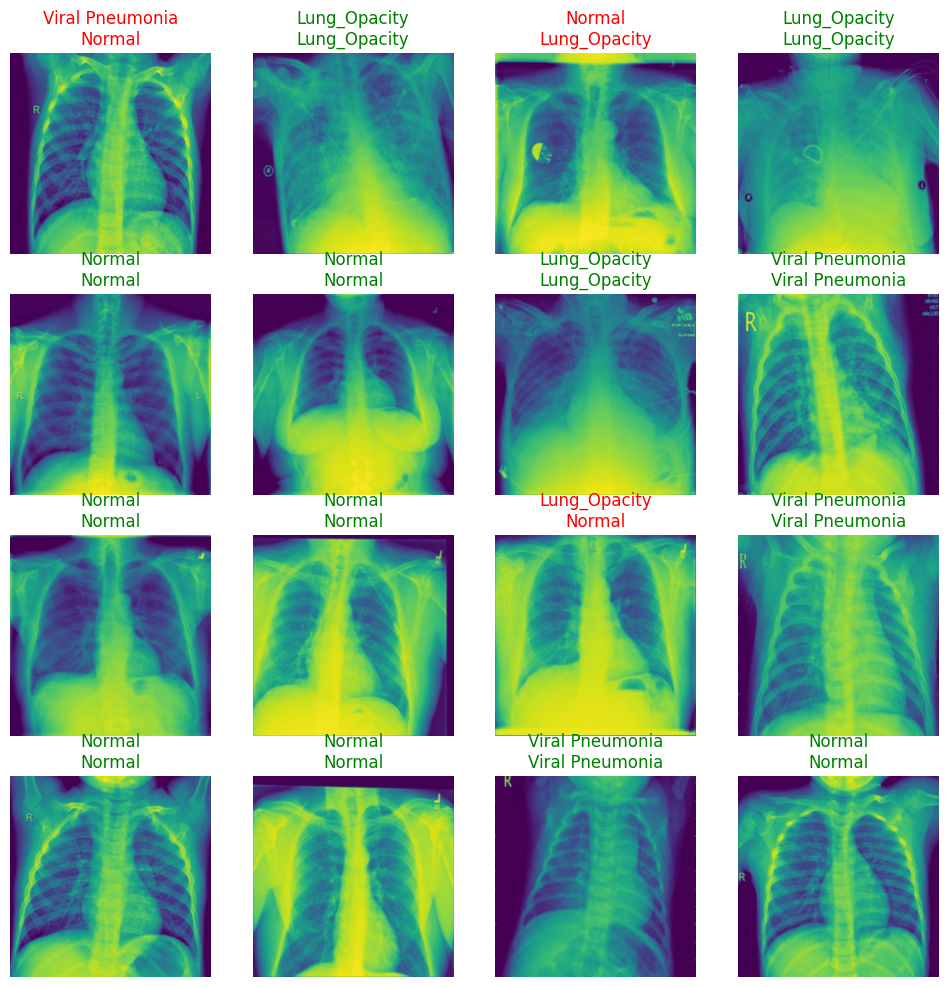

In [31]:
learn.show_results(max_n=16)

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Model Evaluation </h3>
    
</div>


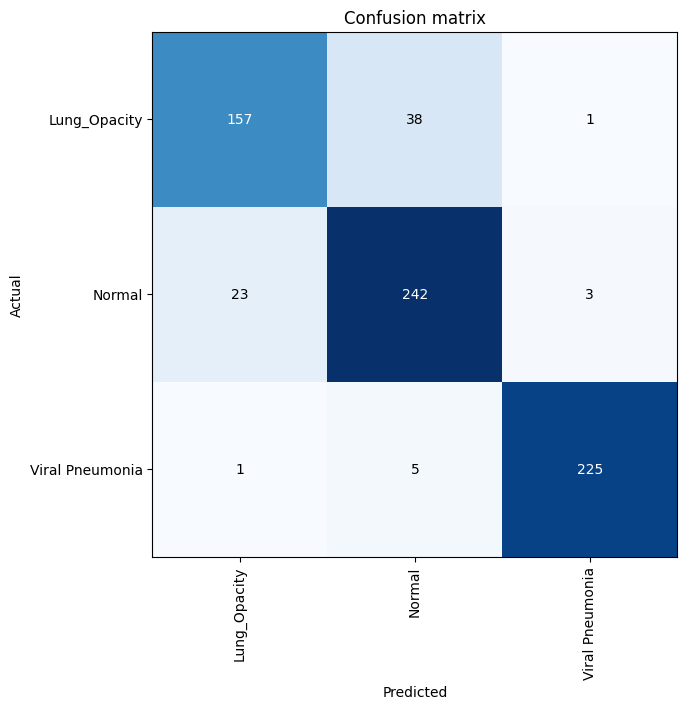

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

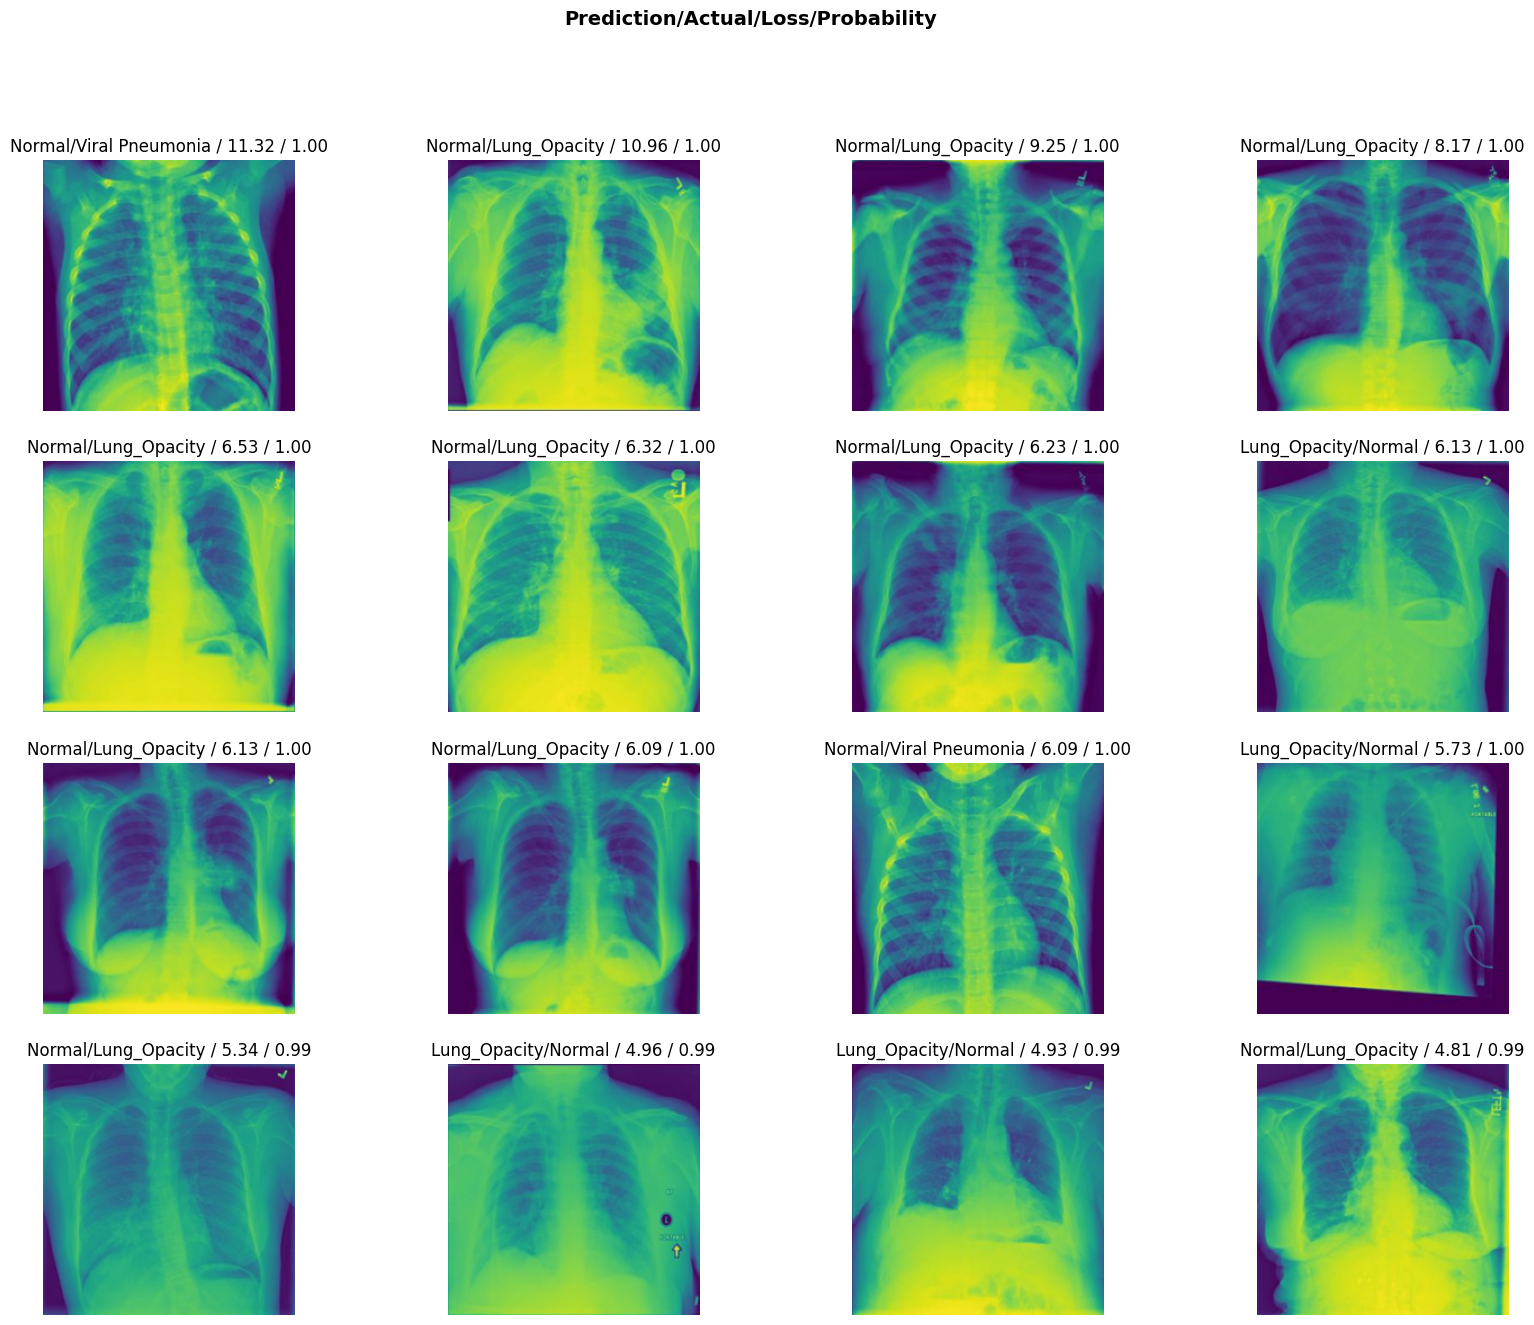

In [33]:
interp.plot_top_losses(16,figsize = (20,15))

In [34]:
preds, targets = learn.get_preds()

class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

                 precision    recall  f1-score   support

   Lung_Opacity       0.87      0.80      0.83       196
         Normal       0.85      0.90      0.88       268
Viral Pneumonia       0.98      0.97      0.98       231

       accuracy                           0.90       695
      macro avg       0.90      0.89      0.90       695
   weighted avg       0.90      0.90      0.90       695



<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 20px; font-weight: bold; color: #20639B; margin-bottom: 10px;"> Model Saving  </h3>
    
</div>


In [35]:
learn.export('Lung Disease_model.pkl')

print("Model trained and saved successfully!")

Model trained and saved successfully!
